# Classfication Network Architecture

BatchNorm has some issue in tf2.0. The github issues say that the behaviour has changed and we need to be mindful of the flag `training:False | True`. This notebook attempts to figure out how to get BN to work in TF 2.x.

In my previous notebooks, I have had dismal performance whenever I used BN.

@date: 02-Sep-2020 | @author: katnoria

In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras import Model

In [9]:
def version_info(cls):
    print(f"{cls.__name__}: {cls.__version__}")

In [10]:
print("Version Used in this Notebook:")
version_info(tf)
version_info(tfds)

Version Used in this Notebook:
tensorflow: 2.3.0
tensorflow_datasets: 3.2.1


In [11]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [12]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


# Dataset

Tensorflow Datasets already provides this dataset in a format that we can use out of the box.

In [13]:
# Load the dataset
(ds_train, ds_test), metadata = tfds.load(
    'cifar10', split=['train', 'test'], shuffle_files=True, 
    with_info=True, as_supervised=True
)

In [14]:
len(ds_train), len(ds_test), metadata.features['label'].num_classes

(50000, 10000, 10)

Use the built in function to visualise the dataset 

In [15]:
# Review metadata
# See https://www.tensorflow.org/datasets/overview
metadata.features

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})

In [16]:
NUM_CLASSES = metadata.features["label"].num_classes

num_train_examples = len(ds_train)
num_test_examples = len(ds_test)
print(f"Training dataset size: {num_train_examples}")
print(f"Test dataset size: {num_test_examples}")

Training dataset size: 50000
Test dataset size: 10000


### Training Pipeline

In [17]:
IMG_SIZE = 32
BATCH_SIZE = 256


def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
#     image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image / 255., label

In [18]:
train_ds = ds_train.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .cache() \
    .shuffle(num_train_examples).batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

In [19]:
example = ds_train.take(1)

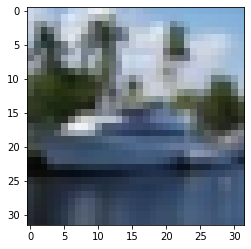

In [20]:
for images, labels in example:
    plt.imshow(images)

### Evaluation Pipeline

In [21]:
test_ds = ds_test.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .cache() \
    .batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

# Build Model

We now build a simple convolution neural network

# Use Pretrained Models

Instead of training the full model, it is generally a good practice to use a pretrained network as a base model and add your layers on top. 
This allows us to reduce the training times and leverage on what base model has learned.

In [22]:
IMG_SIZE = 32
BATCH_SIZE = 128

Do not use the preprocessing we were using earlier, because we now use a pre-trained network as our feature extractor.

In [23]:
train_ds = ds_train \
    .cache() \
    .shuffle(num_train_examples).batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

In [24]:
example = ds_train.take(1)

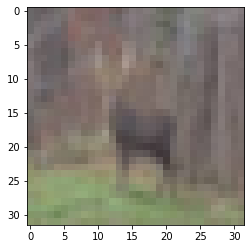

In [25]:
for images, labels in example:
    plt.imshow(images)

### Evaluation Pipeline

In [26]:
test_ds = ds_test \
    .cache() \
    .batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

In [27]:
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
base_model.trainable = False

In [28]:
def get_pretrained_model(base_model):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(NUM_CLASSES)(x)
    _model = tf.keras.Model(inputs, outputs)    
    return _model

In [29]:
resnet_model = get_pretrained_model(base_model)
resnet_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 128)              

In [31]:
# a higher learning rate for BN
lr = 1e-2
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [32]:
resnet_model.evaluate(test_ds)

78/78 [==============================] - 1s 11ms/step - loss: 5.8234 - accuracy: 0.1123


[5.823361396789551, 0.11227964609861374]

In [33]:
# We are going to train for 50 epochs
history = resnet_model.fit(train_ds, epochs=50, validation_data=test_ds, callbacks=[reduce_lr])

Epoch 1/50
386/390 [============================>.] - ETA: 0s - loss: 1.2936 - accuracy: 0.5864WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0041s vs `on_test_batch_end` time: 0.0064s). Check your callbacks.


390/390 [==============================] - 5s 14ms/step - loss: 1.2924 - accuracy: 0.5865 - val_loss: 1.0645 - val_accuracy: 0.6297
Epoch 2/50
390/390 [==============================] - 5s 13ms/step - loss: 1.0096 - accuracy: 0.6498 - val_loss: 1.1006 - val_accuracy: 0.6328
Epoch 3/50
390/390 [==============================] - 5s 14ms/step - loss: 0.9417 - accuracy: 0.6764 - val_loss: 1.0572 - val_accuracy: 0.6471
Epoch 4/50
390/390 [==============================] - 5s 14ms/step - loss: 0.8805 - accuracy: 0.6958 - val_loss: 1.0846 - val_accuracy: 0.6392
Epoch 5/50
390/390 [==============================] - 5s 14ms/step - loss: 0.8338 - accuracy: 0.7109 - val_loss: 1.1357 - val_accuracy: 0.6349
Epoch 6/50
390/390 [==============================] - 5s 14ms/step - loss: 0.7880 - accuracy: 0.7281 - val_loss: 1.2196 - val_accuracy: 0.6260
Epoch 7/50
390/390 [==============================] - 5s 14ms/step - loss: 0.7610 - accuracy: 0.7369 - val_loss: 1.2173 - val_accuracy: 0.6284
Epoch 8/50

### Plot the plots

In [34]:
def plot_history(history):
    plt.style.use('seaborn')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))    

    ax1.plot(acc, label="Training Accuracy")
    ax1.plot(val_acc, label="Validation Accuracy")
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')    
    ax1.legend(loc='lower right')
    ax1.set_title("Training and Validation Accuracy")
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    ax2.plot(loss, label="Training Loss")
    ax2.plot(val_loss, label="Validation Loss")
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')    
    ax2.legend(loc='upper right')
    ax2.set_title("Training and Validation Loss")
    
    plt.show()

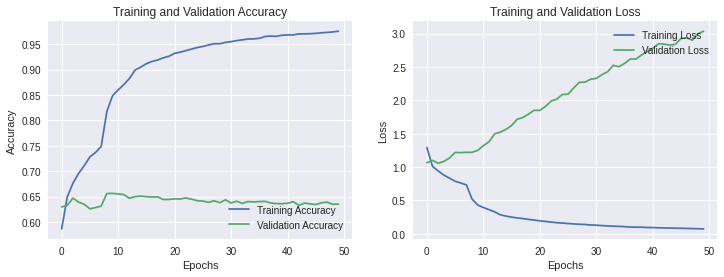

In [35]:
plot_history(history)

# Model 2: Remove Dense Layers

Our model is overfitting so we can try to reduce the capacity of our network

In [36]:
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
base_model.trainable = False

In [37]:
def get_pretrained_model_no_dense(base_model):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    outputs = Dense(NUM_CLASSES)(x)
    _model = tf.keras.Model(inputs, outputs)    
    return _model

In [38]:
resnet_no_dense_model = get_pretrained_model_no_dense(base_model)
resnet_no_dense_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_BiasAdd_1 (Tenso [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

In [ ]:
# a higher learning rate for BN
lr = 1e-2
resnet_no_dense_model.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

# We are going to train for 50 epochs
history = resnet_no_dense_model.fit(train_ds, epochs=50, validation_data=test_ds, callbacks=[reduce_lr])

Epoch 1/50
390/390 [==============================] - 6s 15ms/step - loss: 1.6091 - accuracy: 0.5808 - val_loss: 1.1939 - val_accuracy: 0.6297
Epoch 2/50
116/390 [=======>......................] - ETA: 3s - loss: 1.0375 - accuracy: 0.6583

In [ ]:
plot_history(history)